<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Определение-перспективного-тарифа-для-телеком-компании" data-toc-modified-id="Определение-перспективного-тарифа-для-телеком-компании-1">Определение перспективного тарифа для телеком-компании</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.1">Предобработка данных</a></span></li><li><span><a href="#Описание-тарифов" data-toc-modified-id="Описание-тарифов-1.2">Описание тарифов</a></span></li><li><span><a href="#Рассчёт-прибыли" data-toc-modified-id="Рассчёт-прибыли-1.3">Рассчёт прибыли</a></span></li><li><span><a href="#Анализ-полученных-данных" data-toc-modified-id="Анализ-полученных-данных-1.4">Анализ полученных данных</a></span><ul class="toc-item"><li><span><a href="#Выводы-по-характеристикам-распределения" data-toc-modified-id="Выводы-по-характеристикам-распределения-1.4.1">Выводы по характеристикам распределения</a></span></li></ul></li><li><span><a href="#Проверка-гипотез" data-toc-modified-id="Проверка-гипотез-1.5">Проверка гипотез</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2">Выводы</a></span></li></ul></div>

# Определение перспективного тарифа для телеком-компании

Компания **Мегалайн** - федеральный оператор сотовой связи, предлагает клиентам два тарифных плана: `Смарт` и `Ультра`. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.


Неодходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей **Мегалайна**: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод - какой тариф лучше.

## Предобработка данных

**Импортируем необходимые библиотеки.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import seaborn as sns
from scipy import stats as st

**Загрузим датасеты, сохраним в переменные и подготовим данные для дальнейшего анализа.**

In [2]:
try:
    calls = pd.read_csv('D:/datasets/calls.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


**Датасет calls содержит информацию о звонках:**
* `id` - уникальный номер звонка;
* `call_date` - дата звонка;
* `duration` - длительность звонка в минутах;
* `user_id` - идентификатор пользователя, сделавшего звонок.


**Посмотрим общую информацию о таблице.**

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


* В таблице 202 607 строк, 4 столбца, пропущенных значений нет.

**Изменим тип столбца `user_id` на *object*, а `call_date` на тип *datetime64*. Так же переименуем `id` - уникальный номер звонка, на `call_id`.**

In [5]:
calls['user_id'] = calls['user_id'].astype('object')
calls['call_date'] = calls['call_date'].astype('datetime64')
calls = calls.rename(columns={'id': 'call_id'})

In [6]:
calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0


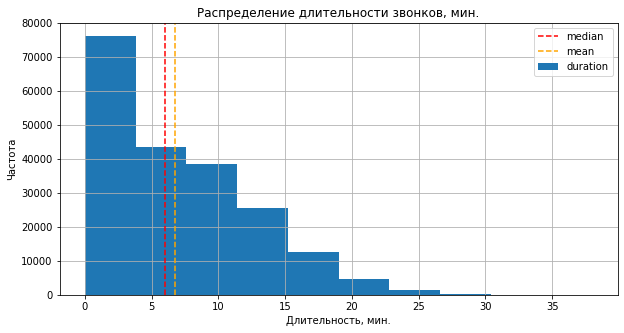

In [7]:
calls.plot(y='duration', kind='hist', figsize=(10,5), bins=10, grid=True, range=(0, 38))
plt.axvline(calls['duration'].median(), color='red', linestyle='--', label='median')
plt.axvline(calls['duration'].mean(), color='orange', linestyle='--', label='mean')
plt.title('Распределение длительности звонков, мин.')
plt.xlabel('Длительность, мин.')
plt.ylabel('Частота')
plt.legend();

* Длительность большинства звонков находится в диапазоне 0 - 4 минуты. Средняя продолжительность звонка - 6.7 минут, медиана - 6 минут, минимальная - 0, максимальная продолжительность - 38 минут.

**Добавим в таблицу столбец `month` и выделим месяц из даты `call_date`, затем округлим количесво минут к большему целому числу, так как *Мегалайн* всегда округляет секунды до минут, каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.**

In [8]:
calls['month'] = calls['call_date'].dt.month
calls['duration'] = np.ceil(calls['duration'])
calls.head()

,call_id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


**Посчитаем количество сделанных звонков и количество израсходованных минут разговора для каждого пользователя по месяцам.**

In [9]:
calls = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count']).reset_index()
calls.columns = ['user_id', 'month', 'call_duration', 'calls_count']
calls.head()

,user_id,month,call_duration,calls_count
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


**Обработаем данные и произведем необходимые рассчёты в таблице messages.**

In [10]:
try:
    messages = pd.read_csv('D:/datasets/messages.csv')
except:
    messages = pd.read_csv('/datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


**Посмотрим общую информацию о таблице.**

In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


**Таблица messages содержит информацию о сообщениях:**
* `id` - уникальный номер сообщения;
* `message_date` - дата сообщения;
* `user_id` - идентификатор пользователя, отправившего сообщение.

* В таблице 123 036 строк, 3 столбца, пропущенных значений нет.


**Изменим типы столбцов `message_date` на *datetime64* и `user_id` на *object*.**

In [12]:
messages['message_date'] = messages['message_date'].astype('datetime64')
messages['user_id'] = messages['user_id'].astype('object')

**Посчитаем для каждого пользователя количество отправленных сообщений по месяцам.**

In [13]:
# выделим из даты месяц и добавим в таблицу столбец month
messages['month'] = messages['message_date'].dt.month

In [14]:
# считаем для каждого пользователя количество отправленных сообщений по месяцам
messages = pd.pivot_table(messages, index=['user_id', 'month'], values='id', aggfunc='count')
messages = messages.rename(columns={'id': 'message_count'})
messages.head()

message_count
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57

**Обработаем и произведём необходимые расчёты в таблице internet.**

In [15]:
try:
    internet = pd.read_csv('D:/datasets/internet.csv', index_col=0)
except:
    internet = pd.read_csv('/datasets/internet.csv')
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


**Таблица internet содержит информацию об интернет-сессиях:**
* `id` - уникальный номер сессии;
* `mb_used` - объём потраченного за сессию интернет-трафика (в мегабайтах);
* `session_date` - дата интернет-сессии;
* `user_id` - идентификатор пользователя.


 **Посмотрим общую информацию о таблице.**

In [16]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


* В таблице 149 396 строк и 5 столбцов, пропущенных значений нет.

**Изменим тип столбца `session_date` на *datetime64* и `user_id` на *object* и переименуем столбец `id` - уникальный номер сессии, на `session_id`.**

In [17]:
internet['session_date'] = internet['session_date'].astype('datetime64')
internet['user_id'] = internet['user_id'].astype('object')
internet = internet.rename(columns={'id': 'session_id'})

In [18]:
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83


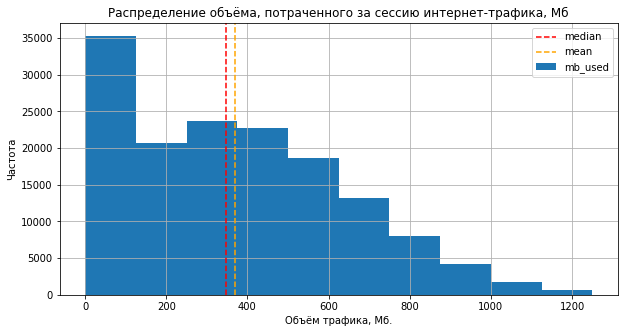

In [19]:
internet.plot(y='mb_used', kind='hist', figsize=(10,5), grid=True, range=(0, 1250), bins=10)
plt.axvline(internet['mb_used'].median(), color='red', linestyle='--', label='median')
plt.axvline(internet['mb_used'].mean(), color='orange', linestyle='--', label='mean')
plt.title('Распределение объёма, потраченного за сессию интернет-трафика, Мб')
plt.xlabel('Объём трафика, Мб.')
plt.ylabel('Частота')
plt.legend();

* Большинство значений потраченного трафика за сессию находится в диапазоне 0 - 200 мб. Средний объём  - 370.19 мегабайт,  медиана - 348.015, минимальный - 0, максимальный объём трафика - 1724.83 мегабайт.

**Добавим столбец `month` и выделим из столбца `session_date` месяц и переведём столбец `mb_used` - объём потраченного за сессию интернет - трафика (в мегабайтах) в гигабайты, разделим на 1024 (столько мегабайт в одном гигабайте) и переименуем сразу столбец.**

In [20]:
internet['month'] = internet['session_date'].dt.month
internet['mb_used'] = internet['mb_used'] / 1024
internet = internet.rename(columns={'mb_used': 'gb_used'})
internet.head()

,session_id,gb_used,session_date,user_id,month
0,1000_0,0.110303,2018-11-25,1000,11
1,1000_1,1.028135,2018-09-07,1000,9
2,1000_2,1.169199,2018-06-25,1000,6
3,1000_3,0.537373,2018-08-22,1000,8
4,1000_4,0.295469,2018-09-24,1000,9


**Округлим столбец `gb_used` до целого числа вверх, (так как "Мегалайн" всегда округляет мегабайты до гигабайт) и посчитаем для каждого пользователя объём израсходованного интернет-трафика по месяцам.**

In [21]:
# подсчёт потраченных гигабайт
internet = pd.pivot_table(internet, index=['user_id', 'month'], values='gb_used', aggfunc='sum').reset_index()
internet['gb_used'] = np.ceil(internet['gb_used'])
internet.head(10)

,user_id,month,gb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0
5,1000,10,15.0
6,1000,11,15.0
7,1000,12,10.0
8,1001,11,18.0
9,1001,12,14.0


**Обработаем данные и произведём необходимые рассчёты в таблице `tariffs`.**

In [22]:
try:
    tariffs = pd.read_csv('D:/datasets/tariffs.csv')
except:
    tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [23]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Таблица tariffs содержит информацию о тарифах:**
* `tariff_name` - название тарифа;
* `rub_monthly_fee` - ежемесячная абонентская плата в рублях;
* `minutes_included` - количество минут разговора в месяц, включённых в абонентскую плату;
* `messages_included` - количество сообщений в месяц, включённых в абонентскую плату;
* `mb_per_month_included` - объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
* `rub_per_minute` - стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
* `rub_per_message` - стоимость отправки сообщения сверх тарифного пакета;
* `rub_per_gb` - стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

В таблице 2 строки и 8 столбцов, пропущенных значений нет.

## Описание тарифов

 **Тариф «Smart»**
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей
    
**Тариф «Ultra»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

In [24]:
# переведём значения включенного объёма интернет-трафика в тариф в Гб
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


**Загрузим таблицу users**

In [25]:
try:
    users = pd.read_csv('D:/datasets/users.csv')
except:
    users = pd.read_csv('/datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [27]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


**Таблица users содержит информацию о пользователях:**
* `user_id` - уникальный идентификатор пользователя;
* `first_name` - имя пользователя;
* `last_name` - фамилия пользователя;
* `age` - возраст пользователя (годы);
* `reg_date` - дата подключения тарифа (день, месяц, год);
* `churn_date` - дата прекращения пользования тарифом;
* `city` - город проживания пользователя;
* `tariff` - название тарифного плана.


В таблице 500 строк и 8 столбцов, есть пропущенные значения в столбце `churn_date` - дата прекращения пользования тарифом, если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Заменим в этом столбце пропуски на значение - 'valid' (действующий). Средний возраст пользователей 46 лет, минимальный 18, максимальный 75.


**Изменим типы столбцов `user_id` на *object*, `reg_date` на *datetime64*.**

In [28]:
users = users.rename(columns={'tariff': 'tariff_name'})
users['churn_date'] = users['churn_date'].fillna('valid')
users['user_id'] = users['user_id'].astype('object')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

**Объединим сводные таблицы для дальнейших исследований.**

In [29]:
# объединение таблиц с информацией о минутах и гигабайтах
data = (calls
    .merge(internet, on=['user_id', 'month'], how='outer').reset_index(drop=True))
data.head()

,user_id,month,call_duration,calls_count,gb_used
0,1000,5,159.0,22.0,3.0
1,1000,6,172.0,43.0,23.0
2,1000,7,340.0,47.0,14.0
3,1000,8,408.0,52.0,14.0
4,1000,9,466.0,58.0,15.0


In [30]:
# присоединение таблицы с данными о смс
data = (data
    .merge(messages, on=['user_id', 'month'], how='outer').reset_index(drop=True))
data.head()

,user_id,month,call_duration,calls_count,gb_used,message_count
0,1000,5,159.0,22.0,3.0,22.0
1,1000,6,172.0,43.0,23.0,60.0
2,1000,7,340.0,47.0,14.0,75.0
3,1000,8,408.0,52.0,14.0,81.0
4,1000,9,466.0,58.0,15.0,57.0


In [31]:
# присоединение таблицы с пользователями
data = (data
    .merge(users, on='user_id', how='left').reset_index(drop=True))
data.head()

,user_id,month,call_duration,calls_count,gb_used,message_count,age,churn_date,city,first_name,last_name,reg_date,tariff_name
0,1000,5,159.0,22.0,3.0,22.0,52,valid,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172.0,43.0,23.0,60.0,52,valid,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340.0,47.0,14.0,75.0,52,valid,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408.0,52.0,14.0,81.0,52,valid,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466.0,58.0,15.0,57.0,52,valid,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [32]:
# присоединение к таблице информации о тарифах
data = (data
       .merge(tariffs, on='tariff_name', how='outer').reset_index(drop=True))
data.head()

,user_id,month,call_duration,calls_count,gb_used,message_count,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,3.0,22.0,52,valid,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1000,6,172.0,43.0,23.0,60.0,52,valid,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
2,1000,7,340.0,47.0,14.0,75.0,52,valid,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
3,1000,8,408.0,52.0,14.0,81.0,52,valid,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
4,1000,9,466.0,58.0,15.0,57.0,52,valid,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1


**Удалим столбцы, которые не понадобятся в исследовании.**

In [33]:
data.drop(columns=['age', 'first_name', 'last_name'], axis=1, inplace=True)
data.head()

,user_id,month,call_duration,calls_count,gb_used,message_count,churn_date,city,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,3.0,22.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1000,6,172.0,43.0,23.0,60.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
2,1000,7,340.0,47.0,14.0,75.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
3,1000,8,408.0,52.0,14.0,81.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
4,1000,9,466.0,58.0,15.0,57.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1


**Проверим пропуски в таблице.**

In [34]:
data.isna().sum()

user_id                    0
month                      0
call_duration             40
calls_count               40
gb_used                   11
message_count            497
churn_date                 0
city                       0
reg_date                   0
tariff_name                0
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

* В таблице есть пропущенные значения, клиент может не пользоваться смс или интернетом или звонками, заменим пропущенные значения на 0.

In [35]:
data[['call_duration', 'calls_count', 'gb_used']] = data[['call_duration', 'calls_count', 'gb_used']].fillna(0)
data[['call_duration', 'calls_count', 'gb_used']] = data[['call_duration', 'calls_count', 'gb_used']].astype('int64')

**Проверим таблицу на дубликаты.**

In [36]:
data.duplicated().sum()

0

In [37]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


## Рассчёт прибыли

**Посчитаем для каждого пользователя помесячную выручку, с помощью функции.**

In [38]:
def profit(i):
    if i['tariff_name'] == 'smart':
        if i['call_duration'] > i['minutes_included']:
            calls = (i['call_duration'] - i['minutes_included']) * i['rub_per_minute']
        else:
            calls = 0
        if i['message_count'] > i['messages_included']:
            messages = (i['message_count'] - i['messages_included']) * i['rub_per_message']
        else:
            messages = 0
        if i['gb_used'] > i['mb_per_month_included']:
            internet = (i['gb_used'] - i['mb_per_month_included']) * i['rub_per_gb']
        else:
            internet = 0
        total = calls + messages + internet + i['rub_monthly_fee']
        
    if i['tariff_name'] == 'ultra':
        if i['call_duration'] > i['minutes_included']:
            calls = (i['call_duration'] - i['minutes_included']) * i['rub_per_minute']
        else:
            calls = 0
        if i['message_count'] > i['messages_included']:
            messages = (i['message_count'] - i['messages_included']) * i['rub_per_message']
        else:
            messages = 0
        if i['gb_used'] > i['mb_per_month_included']:
            internet = (i['gb_used'] - i['mb_per_month_included']) * i['rub_per_gb']
        else:
            internet = 0
        total = calls + messages + internet + i['rub_monthly_fee']
    return total

data['profit'] = data.apply(profit, axis=1)
data.head()

,user_id,month,call_duration,calls_count,gb_used,message_count,churn_date,city,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,5,159,22,3,22.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
1,1000,6,172,43,23,60.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
2,1000,7,340,47,14,75.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
3,1000,8,408,52,14,81.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
4,1000,9,466,58,15,57.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0


## Анализ полученных данных

**Посмотрим как распределяются пользователи по тарифам.**

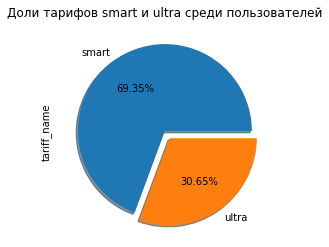

In [39]:
data['tariff_name'].value_counts().plot(kind = 'pie', autopct='%1.2f%%', explode = (0, 0.1), shadow = True)
plt.title('Доли тарифов smart и ultra среди пользователей')
plt.show()

* 69.35% клиентов пользуются тарифом `Smart` и 30.65% предпочитают тариф `Ultra`.


**Выделим пользователей каждого тарифа в отдельные таблицы и сохраним в переменные.**

In [40]:
smart = data.query('tariff_name == "smart"') # пользователи тарифа smart
ultra = data.query('tariff_name == "ultra"') # пользователи тарифа ultra

**Построим гисторгаммы распределений использованных минут, смс, гигабайт по двум тарифам.**

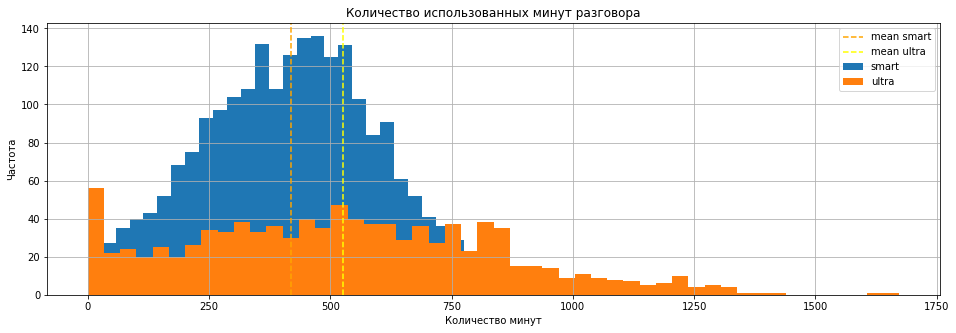

In [41]:
plt.figure(figsize=(16, 5));
smart['call_duration'].plot(grid=True, bins=50, kind='hist', alpha=1, label='smart');
ultra['call_duration'].plot(grid=True, bins=50, kind='hist', alpha=1, label='ultra');
plt.title('Количество использованных минут разговора');
plt.xlabel('Количество минут');
plt.ylabel('Частота');
plt.axvline(smart['call_duration'].mean(), color='orange', linestyle='--', label='mean smart')
plt.axvline(ultra['call_duration'].mean(), color='yellow', linestyle='--', label='mean ultra')
plt.legend()
plt.show();

* Пользователи тарифа `Smart` в среднем используют 417 минут, (в тариф включено 500 минут). Некоторые пользователи превышают лимит, максимальное количество израсходованных минут 1435. Большинство значений находятся в диапазоне примерно от 400 до 550 минут.


* Пользователи тарифа `Ultra` используют в среднем 526 минут, (в тариф включено 3000 минут). Пользователи не превышают этот лимит, максимальное количество  израсходованных минут 1673.

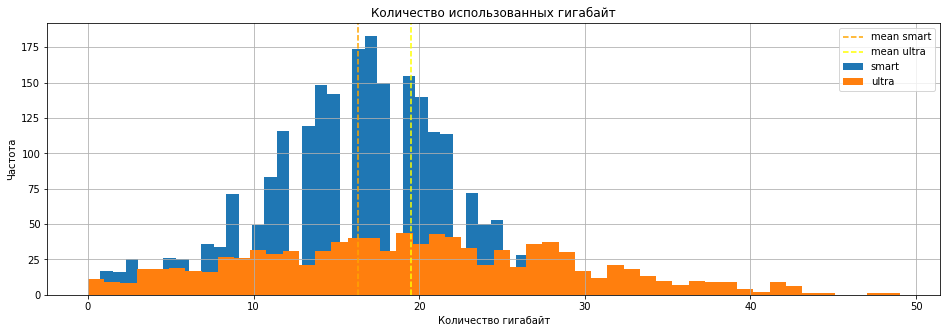

In [42]:
plt.figure(figsize=(16, 5))
smart['gb_used'].plot(grid=True, bins=50, kind='hist', alpha=1, label='smart')
ultra['gb_used'].plot(grid=True, bins=50, kind='hist', alpha=1, label='ultra')
plt.title('Количество использованных гигабайт');
plt.xlabel('Количество гигабайт')
plt.ylabel('Частота')
plt.axvline(smart['gb_used'].mean(), color='orange', linestyle='--', label='mean smart')
plt.axvline(ultra['gb_used'].mean(), color='yellow', linestyle='--', label='mean ultra')
plt.legend();

* Пользователи тарифа `Smart` в среднем используют 42 гигабайта, (в тариф включено 15 гигабайт). Многие пользователи превышают лимит, максимальное количество - 101 гигабайт. Большинство значений находятся в диапазоне примерно от 40 до 50 гигабайт.


* Пользователи тарифа `Ultra` используют в среднем 38 гигабайт, (в тариф включено 30 гигабайт). Пользователи тарифа 'Ultra' так же превышают этот лимит, максимальное количество израсходованных гигабайт - 98.

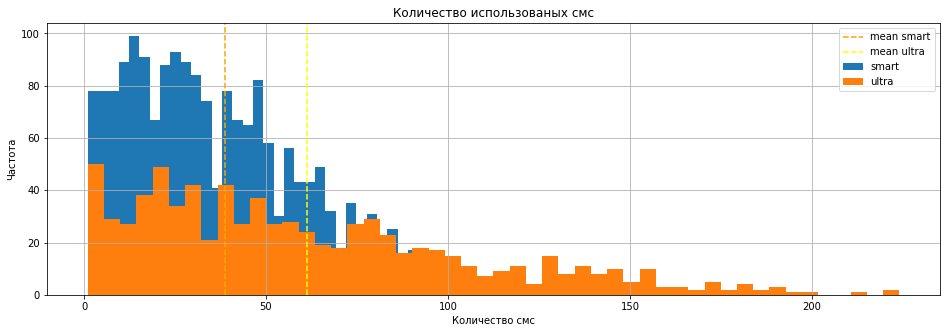

In [43]:
plt.figure(figsize=(16, 5))
smart['message_count'].plot(grid=True, bins=50, kind='hist', alpha=1, label='smart')
ultra['message_count'].plot(grid=True, bins=50, kind='hist', alpha=1, label='ultra')
plt.title('Количество использованых смс')
plt.xlabel('Количество смс')
plt.ylabel('Частота')
plt.axvline(smart['message_count'].mean(), color='orange', linestyle='--', label='mean smart')
plt.axvline(ultra['message_count'].mean(), color='yellow', linestyle='--', label='mean ultra')
plt.legend();

* Пользователи тарифа `Smart` в среднем отправляют 38 смс, (в тариф включено 50 смс). Немногие пользователи превышают этот лимит, максимальное количество отправленных смс 143. Большинство значений находятся в диапазоне примерно от 30 до 50.


* Пользователи тарифа `Ultra` отправляют в среднем 61 смс, (в тариф включено 1000 смс). Пользователи не превышают этот лимит, максимальное количество отправленных смс 224.

**Посчитаем среднее значение, дисперсию и стандартное отклонение по прибыли, количеству смс, минут и гигабайт.**

In [44]:
statistics = data.pivot_table(index=['tariff_name'], values=['call_duration', 'gb_used', 'message_count'], 
                    aggfunc={'call_duration': [np.mean, np.median, np.var, np.std], 
                             'gb_used': [np.mean, np.median, np.var, np.std], 
                          'message_count': [np.mean, np.median, np.var, np.std]})
display(statistics)

call_duration                                      gb_used         \
                     mean median         std            var       mean median   
tariff_name                                                                     
smart          417.934948  422.0  190.313730   36219.315784  16.328847   17.0   
ultra          526.623350  518.0  317.606098  100873.633397  19.494416   19.0   

                                 message_count                                 
                  std        var          mean median        std          var  
tariff_name                                                                    
smart        5.747061  33.028705     38.716441   34.0  26.787949   717.594201  
ultra        9.853511  97.091686     61.161006   51.0  45.931026  2109.659183

### Выводы по характеристикам распределения

Средняя длительность разговора не сильно зависит от тарифа. В среднем человеку нужно около 417 минут разговора на тарифе `Smart` и 526 - на тарифе `Ultra`.
Пользователи обоих тарифов используют смс в пределах лимита, на тарифе `Smart` некоторые абоненты превысили лимит.

Основные различия касаются объема интернет-трафика. Пользователи тарифа `Smart` превышают лимит 15 гигабайт и платят за дополнительные мегабайты. Абоненты тарифа `Ultra` используют интернет активнее, но реже выходят за установленный лимит в 30 гигабайт.

## Проверка гипотез

* Первая гипотеза звучит так: "Средняя выручка пользователей тарифов `Ультра` и `Смарт` различаются."

**Посмотрим на гистограмму распределения прибыли по тарифам.**

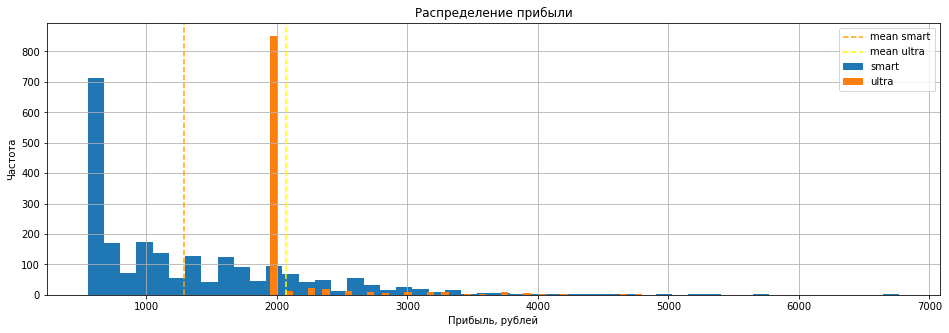

In [45]:
plt.figure(figsize=(16, 5));
smart['profit'].plot(grid=True, bins=50, kind='hist', alpha=1, label='smart')
ultra['profit'].plot(grid=True, bins=50, kind='hist', alpha=1, label='ultra')
plt.title('Распределение прибыли')
plt.xlabel('Прибыль, рублей')
plt.ylabel('Частота')
plt.axvline(smart['profit'].mean(), color='orange', linestyle='--', label='mean smart')
plt.axvline(ultra['profit'].mean(), color='yellow', linestyle='--', label='mean ultra')
plt.legend()
plt.show();

* Средняя прибыль пользователей тарифа `Smart` составляет 1289 рублей. Пик у тарифа smart 550 рублей - это стоимость тарифа. Максимальная прибыль составила 6770 рублей.


* Средняя прибыль пользователей тарифа `Ultra` составляет 2070 рублей. Пик у тарифа ultra 1950 рублей, это так же стоимость тарифа, большинство пользователей не выходят за рамки тарифа. Максимальная прибыль у тарифа `Ultra`составила 4800 рублей.

**Теперь проверим гипотезу.**

Сформулируем нулевую и альтернативную гипотезу:

* H₀ - средняя выручка пользователей тарифов `Ultra` и `Smart` равна.

* H₁ - средняя выручка пользователей тарифов `Ultra` и `Smart` не равна.

Критический уровень статистической значимости укажем 0.05.

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей будем использовать метод `scipy.stats.ttest_ind`.

In [46]:
alpha = 0.05

results = st.ttest_ind(
    smart['profit'],
    ultra['profit']
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Средняя выручка с пользователя тарифа smart -', round(smart['profit'].mean(), 1))
print('Средняя выручка с пользователя тарифа ultra -', round(ultra['profit'].mean(), 1))

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу

Средняя выручка с пользователя тарифа smart - 1290.0
Средняя выручка с пользователя тарифа ultra - 2070.2


**Отвергаем нулевую гипотезу, средняя выручка пользователей тарифа `Ultra` не равна выручке тарифа `Smart`. Средняя выручка пользователей тарифа `Ultra` больше в среднем на 780 рублей.**

* Вторая гипотеза звучит так: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов."

**Сформулируем нулевую и альтернативную гипотезу:**

* H₀ - средняя выручка пользователей из Москвы и других регионов равна.

*  H₁ - средняя выручка пользователей из Москвы и других регионов не равна.

Критический уровень статистической значимости укажем 0.05.

**Выделим пользователей Москвы и пользователей других регионов в две отдельные таблицы.**

In [47]:
moscow = data.query('city == "Москва"')
regions = data.query('city != "Москва"')
display(moscow.head(5))
display(regions.head(5))

,user_id,month,call_duration,calls_count,gb_used,message_count,churn_date,city,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
8,1003,8,380,55,9,37.0,valid,Москва,2018-08-17,ultra,1000,30.0,3000,1950,150,1,1,1950.0
9,1003,9,961,134,13,91.0,valid,Москва,2018-08-17,ultra,1000,30.0,3000,1950,150,1,1,1950.0
10,1003,10,855,108,15,83.0,valid,Москва,2018-08-17,ultra,1000,30.0,3000,1950,150,1,1,1950.0
11,1003,11,824,115,12,94.0,valid,Москва,2018-08-17,ultra,1000,30.0,3000,1950,150,1,1,1950.0
12,1003,12,802,108,10,75.0,valid,Москва,2018-08-17,ultra,1000,30.0,3000,1950,150,1,1,1950.0


,user_id,month,call_duration,calls_count,gb_used,message_count,churn_date,city,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,5,159,22,3,22.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
1,1000,6,172,43,23,60.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
2,1000,7,340,47,14,75.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
3,1000,8,408,52,14,81.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
4,1000,9,466,58,15,57.0,valid,Краснодар,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0


In [48]:
alpha = 0.05

results = st.ttest_ind(
    moscow['profit'],
    regions['profit']
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Средняя выручка в месяц с пользователя в Москве -', round(moscow['profit'].mean(), 1))
print('Средняя выручка в месяц с пользователя в других регионах -', round(regions['profit'].mean(), 1))

p-значение: 0.5440152911670223
Не получилось отвергнуть нулевую гипотезу

Средняя выручка в месяц с пользователя в Москве - 1546.7
Средняя выручка в месяц с пользователя в других регионах - 1524.9


* Нулевую гипотезу отвергнуть не получилось так как, средняя выручка в Москве и за её пределами почти не отличается от выручки в других регионах.

# Выводы

* Были обработан и проанализирован полученный архив данных, заполнены пропущенные значения там, где это необходимо. Выявлены и проанализированы аномальные значения.

* Данные приведены к нужным типам, найдены и исправлены ошибки.

Проведя статистический анализ выборки из 500 абонентов сотового оператора **Мегалайн**, можно сделать следующие выводы:

* 69.35% клиентов пользуются тарифом `Smart` и 30.65% предпочитают тариф `Ultra`.


* Пользователи больше предпочитают тариф `Smart`, вероятнее потому, что он доступнее по цене.


* Пользователи обоих тарифов не выходят за рамки лимитов по смс и минутам.


* Интернет абоненты используют охотнее, в обоих тарифах пользователи превышают лимит установленный оператором.


* Гипотеза о том, что средняя выручка в Москве отличается от выручки в других регионах не подтвердилась, выручка почти не отличается.


* Средняя прибыль пользователей тарифа `Smart` составляет 1289 рублей, а средняя прибыль пользователей тарифа `Ultra` составляет 2070 рублей. Следовательно прибыль от тарифа `Ultra` больше в 1,6 раза. Коммерческому департаменту компании **Мегалайн** следует сделать упор на рекламу тарифу `Ultra`, для привлечения перехода клиентов на этот тариф.